# Merge Accelerometer and Gyroscope datasets
This notebook scans all subfolders, reads `Accelerometer.csv` and `Gyroscope.csv` files, tags each row with `Activity` and `Sensor`, concatenates them into a single DataFrame, and saves both a full merged file and per-activity merged files.

Notes: It assumes folders start with activity names like `Jumping`, `Walking`, `Standing`, `Still`.

In [1]:
# Imports and workspace base path
import os
from pathlib import Path
import pandas as pd
import glob

BASE_DIR = Path(r'c:\Users\HP\Hidden-Markov-Models')
print('Base dir:', BASE_DIR)
# Find the Accelerometer and Gyroscope CSVs
acc_files = sorted(BASE_DIR.glob('**/Accelerometer.csv'))
gyro_files = sorted(BASE_DIR.glob('**/Gyroscope.csv'))
print(f'Found {len(acc_files)} Accelerometer files and {len(gyro_files)} Gyroscope files')
# show some example paths
for p in acc_files[:5]:
    print('ACC sample:', p)
for p in gyro_files[:5]:
    print('GYRO sample:', p)

Base dir: c:\Users\HP\Hidden-Markov-Models
Found 50 Accelerometer files and 50 Gyroscope files
ACC sample: c:\Users\HP\Hidden-Markov-Models\Jumping_1-2025-10-24_13-03-55\Accelerometer.csv
ACC sample: c:\Users\HP\Hidden-Markov-Models\Jumping_1-2025-10-25_05-20-38\Accelerometer.csv
ACC sample: c:\Users\HP\Hidden-Markov-Models\Jumping_1-2025-10-25_05-28-36\Accelerometer.csv
ACC sample: c:\Users\HP\Hidden-Markov-Models\Jumping_1-2025-10-25_05-36-41\Accelerometer.csv
ACC sample: c:\Users\HP\Hidden-Markov-Models\Jumping_1-2025-10-25_05-43-47\Accelerometer.csv
GYRO sample: c:\Users\HP\Hidden-Markov-Models\Jumping_1-2025-10-24_13-03-55\Gyroscope.csv
GYRO sample: c:\Users\HP\Hidden-Markov-Models\Jumping_1-2025-10-25_05-20-38\Gyroscope.csv
GYRO sample: c:\Users\HP\Hidden-Markov-Models\Jumping_1-2025-10-25_05-28-36\Gyroscope.csv
GYRO sample: c:\Users\HP\Hidden-Markov-Models\Jumping_1-2025-10-25_05-36-41\Gyroscope.csv
GYRO sample: c:\Users\HP\Hidden-Markov-Models\Jumping_1-2025-10-25_05-43-47\Gyro

In [2]:
def activity_from_path(p: Path) -> str:
    # Infer activity by the folder name prefix (e.g., 'Jumping_1-...')
    name = p.parent.name
    for act in ('Jumping', 'Walking', 'Standing', 'Still'):
        if name.startswith(act):
            return act
    # fallback: try splitting on underscore or dash
    for sep in ['_', '-']:
        if sep in name:
            return name.split(sep)[0]
    return name

def read_and_tag(file_path: Path, sensor_name: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(file_path)
    except Exception as e:
        print(f'Failed to read {file_path}:', e)
        return pd.DataFrame()
    df = df.copy()
    df['Sensor'] = sensor_name
    df['SourceFile'] = str(file_path)
    df['Activity'] = activity_from_path(file_path)
    return df

# Read all files into a list of DataFrames
dfs = []
for p in acc_files:
    dfs.append(read_and_tag(p, 'Accelerometer'))
for p in gyro_files:
    dfs.append(read_and_tag(p, 'Gyroscope'))

# Concatenate all (ignore empty frames)
if len(dfs) == 0:
    print('No dataframes to concatenate')
else:
    merged = pd.concat([d for d in dfs if not d.empty], ignore_index=True, sort=False)
    print('Merged shape:', merged.shape)
    display(merged.head())

Merged shape: (57870, 8)


,time,seconds_elapsed,z,y,x,Sensor,SourceFile,Activity
0,1761311035749738500,0.209739,-0.073487,0.131348,0.204234,Accelerometer,c:\Users\HP\Hidden-Markov-Models\Jumping_1-202...,Jumping
1,1761311035768349700,0.228350,-0.067876,0.066420,0.140140,Accelerometer,c:\Users\HP\Hidden-Markov-Models\Jumping_1-202...,Jumping
2,1761311035786962400,0.246962,-0.153368,-0.093135,0.078951,Accelerometer,c:\Users\HP\Hidden-Markov-Models\Jumping_1-202...,Jumping
3,1761311035805573600,0.265574,-0.217052,-0.173825,0.062118,Accelerometer,c:\Users\HP\Hidden-Markov-Models\Jumping_1-202...,Jumping
4,1761311035824186400,0.284186,-0.261741,-0.193203,0.045196,Accelerometer,c:\Users\HP\Hidden-Markov-Models\Jumping_1-202...,Jumping


In [3]:
# Save merged outputs into a data/ directory
OUT_DIR = BASE_DIR / 'data'
OUT_DIR.mkdir(exist_ok=True)
if 'merged' in globals() and not merged.empty:
    full_path = OUT_DIR / 'merged_all_sensors.csv'
    merged.to_csv(full_path, index=False)
    print('Saved full merged to', full_path)
    # save per-activity files
    for act, sub in merged.groupby('Activity'):
        fn = OUT_DIR / f'merged_{act}.csv'
        sub.to_csv(fn, index=False)
        print('Saved', fn, 'shape=', sub.shape)
else:
    print('No merged dataframe available to save')

Saved full merged to c:\Users\HP\Hidden-Markov-Models\data\merged_all_sensors.csv
Saved c:\Users\HP\Hidden-Markov-Models\data\merged_Jumping.csv shape= (12207, 8)
Saved c:\Users\HP\Hidden-Markov-Models\data\merged_Standing.csv shape= (15164, 8)
Saved c:\Users\HP\Hidden-Markov-Models\data\merged_Still.csv shape= (12915, 8)
Saved c:\Users\HP\Hidden-Markov-Models\data\merged_Walking.csv shape= (17584, 8)


### Next steps
- Inspect `data/merged_all_sensors.csv` and `data/merged_{activity}.csv`.
- If you want separate files for Accelerometer-only or Gyroscope-only, we can add that export.

In [9]:
# Hidden Markov Models for Human Activity Recognition

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, fft
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Try to import hmmlearn if available; otherwise fall back to the custom GaussianHMM implemented later in this notebook.
try:
    from hmmlearn import hmm
    HMMLEARN_AVAILABLE = True
except Exception:
    HMMLEARN_AVAILABLE = False
    print("hmmlearn not available — the notebook will use a custom GaussianHMM implementation instead.")

print("=== HMM Activity Recognition System ===")

hmmlearn not available — the notebook will use a custom GaussianHMM implementation instead.
=== HMM Activity Recognition System ===


## Data Loading and Preprocessing

Loaded dataset with shape: (57870, 8)

Data Overview:
Activities: ['Jumping' 'Standing' 'Still' 'Walking']
Sensors: ['Accelerometer' 'Gyroscope']
Time range: 0.09 to 12.51 seconds

Missing values: 0

Sample data:


,time,seconds_elapsed,z,y,x,Sensor,SourceFile,Activity
0,1761311035749738500,0.209739,-0.073487,0.131348,0.204234,Accelerometer,c:\Users\HP\Hidden-Markov-Models\Jumping_1-202...,Jumping
1,1761311035768349700,0.228350,-0.067876,0.066420,0.140140,Accelerometer,c:\Users\HP\Hidden-Markov-Models\Jumping_1-202...,Jumping
2,1761311035786962400,0.246962,-0.153368,-0.093135,0.078951,Accelerometer,c:\Users\HP\Hidden-Markov-Models\Jumping_1-202...,Jumping
3,1761311035805573600,0.265574,-0.217052,-0.173825,0.062118,Accelerometer,c:\Users\HP\Hidden-Markov-Models\Jumping_1-202...,Jumping
4,1761311035824186400,0.284186,-0.261741,-0.193203,0.045196,Accelerometer,c:\Users\HP\Hidden-Markov-Models\Jumping_1-202...,Jumping


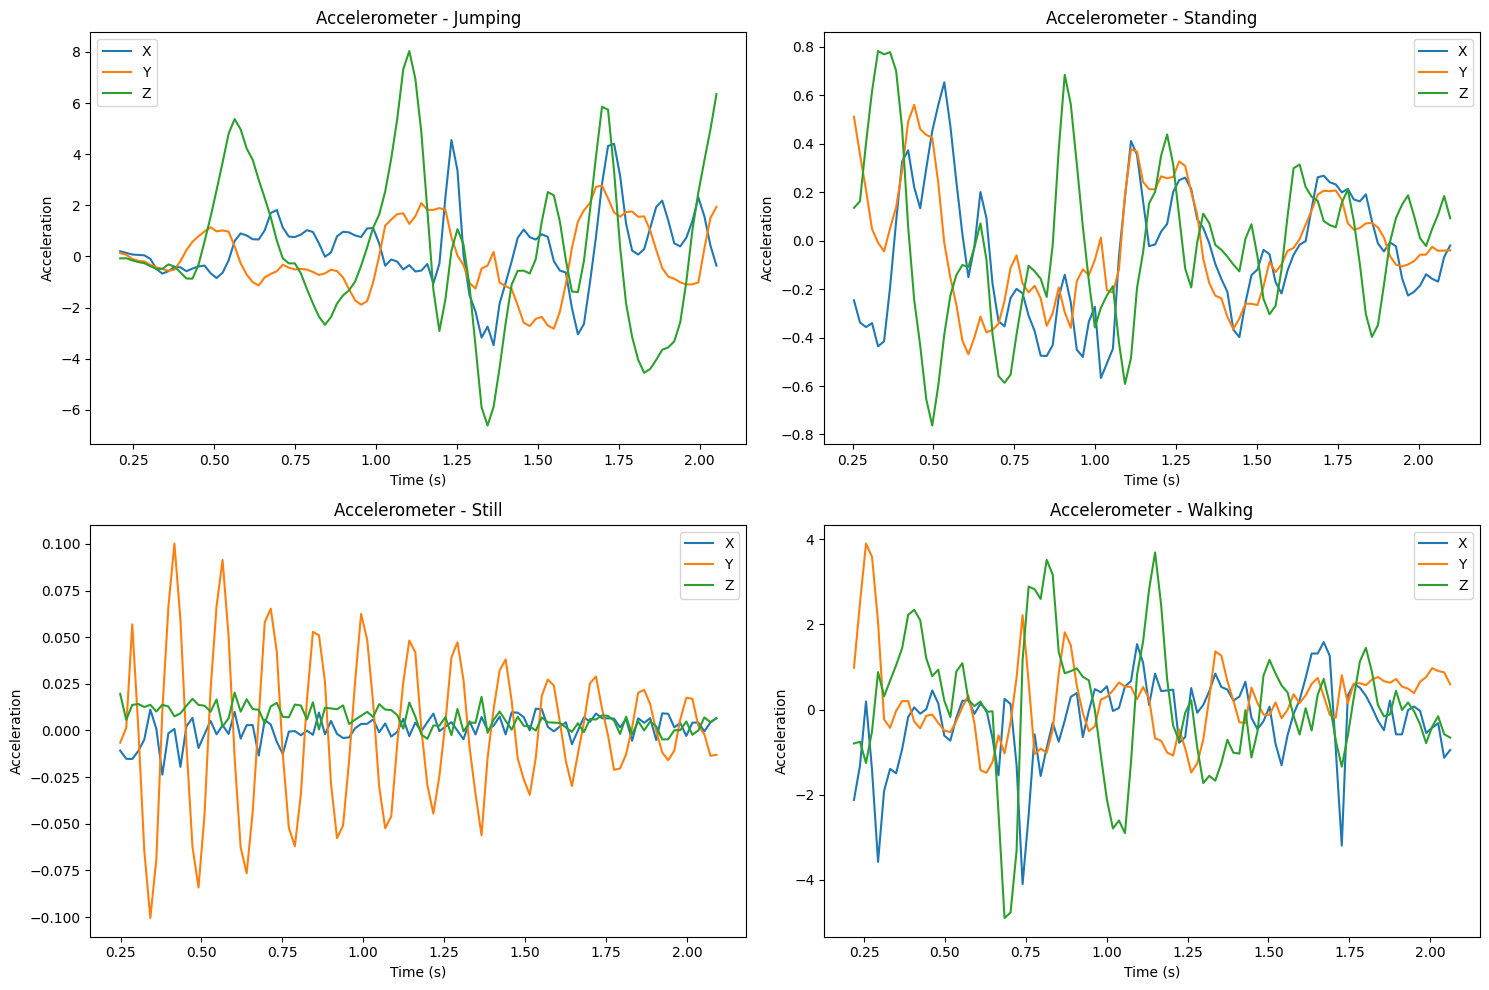

In [10]:
# Load and prepare the merged data
def load_and_prepare_data():
    """Load the merged dataset and prepare for feature extraction"""
    try:
        # Load your merged data
        df = pd.read_csv('data/merged_all_sensors.csv')
        print(f"Loaded dataset with shape: {df.shape}")
        
        # Basic data quality checks
        print("\nData Overview:")
        print(f"Activities: {df['Activity'].unique()}")
        print(f"Sensors: {df['Sensor'].unique()}")
        print(f"Time range: {df['seconds_elapsed'].min():.2f} to {df['seconds_elapsed'].max():.2f} seconds")
        
        # Check for missing values
        print(f"\nMissing values: {df.isnull().sum().sum()}")
        
        return df
    except FileNotFoundError:
        print("Merged data file not found. Please run the data merging first.")
        return None

# Load data
data = load_and_prepare_data()

if data is not None:
    # Display sample data
    print("\nSample data:")
    display(data.head())
    
    # Basic visualization of raw data
    plt.figure(figsize=(15, 10))
    
    # Plot accelerometer data for each activity
    activities = data['Activity'].unique()
    for i, activity in enumerate(activities, 1):
        plt.subplot(2, 2, i)
        activity_data = data[(data['Activity'] == activity) & (data['Sensor'] == 'Accelerometer')]
        plt.plot(activity_data['seconds_elapsed'].values[:100], 
                activity_data['x'].values[:100], label='X')
        plt.plot(activity_data['seconds_elapsed'].values[:100], 
                activity_data['y'].values[:100], label='Y')
        plt.plot(activity_data['seconds_elapsed'].values[:100], 
                activity_data['z'].values[:100], label='Z')
        plt.title(f'Accelerometer - {activity}')
        plt.xlabel('Time (s)')
        plt.ylabel('Acceleration')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

## Comprehensive Feature Extraction

Extracting features from sensor data...
Extracted 411 windows with 59 features

Feature extraction completed!
Final feature matrix shape: (411, 60)
Activity distribution:
activity
Walking     126
Standing    107
Still        92
Jumping      86
Name: count, dtype: int64


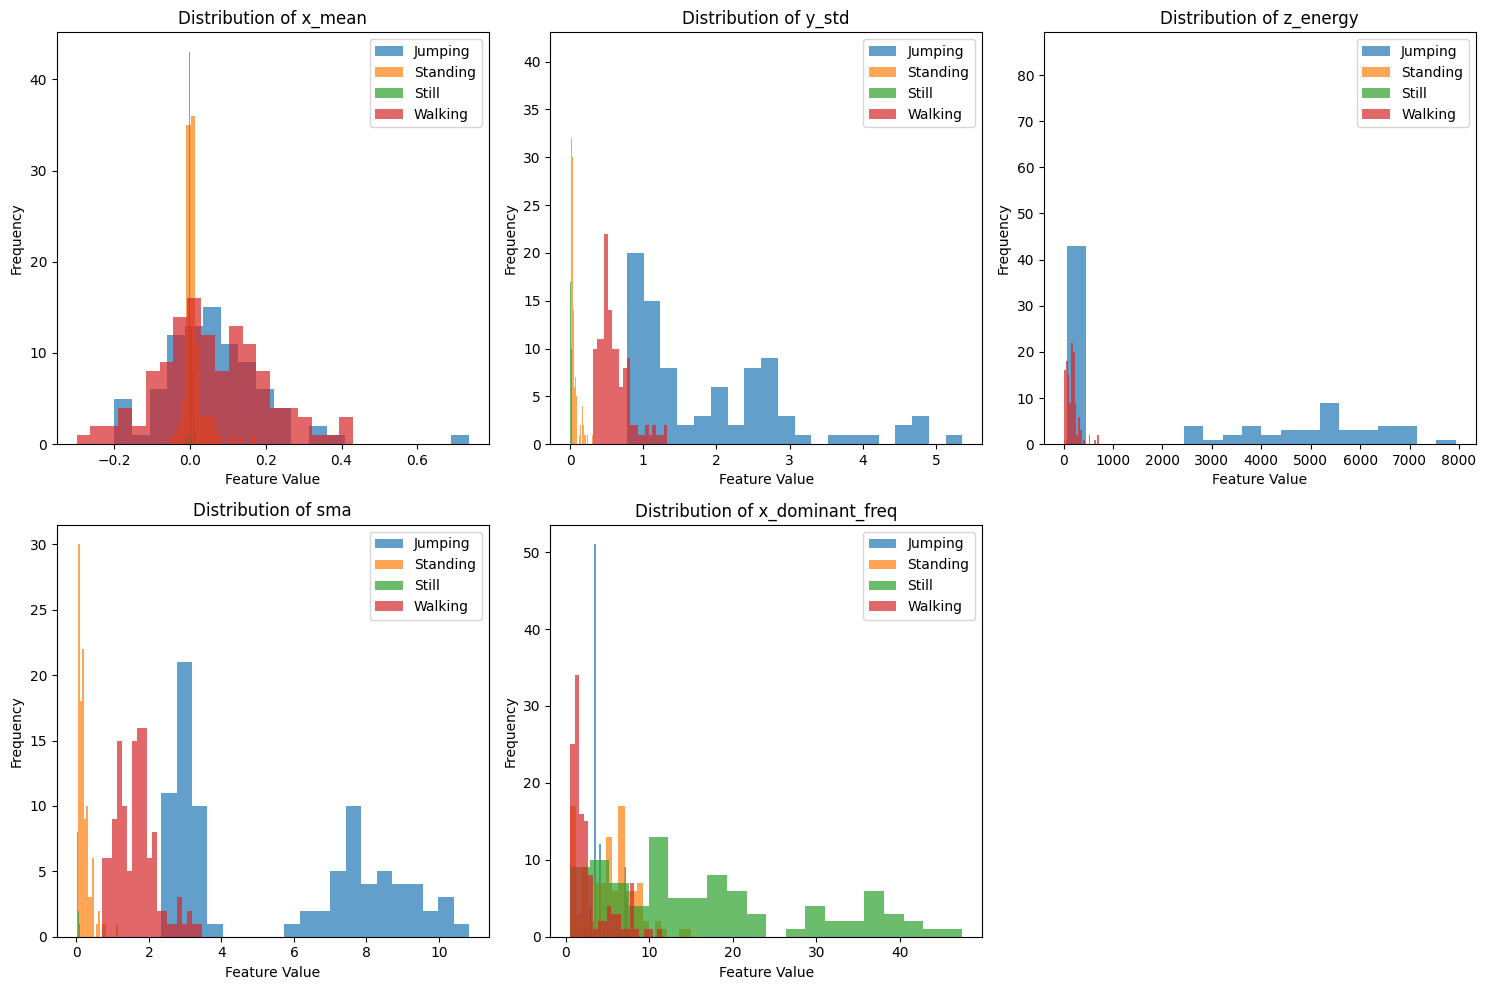

In [11]:
class FeatureExtractor:
    """Extract time and frequency domain features from sensor data"""
    
    def __init__(self, window_size=2.0, overlap=0.5):
        self.window_size = window_size  # in seconds
        self.overlap = overlap
        self.scaler = StandardScaler()
        self.feature_names = []
        
    def _extract_time_features(self, window):
        """Extract time-domain features"""
        features = {}
        
        # Basic statistical features for each axis
        for axis in ['x', 'y', 'z']:
            arr = window[axis].values
            
            # Time-domain features
            features[f'{axis}_mean'] = np.mean(arr)
            features[f'{axis}_std'] = np.std(arr)
            features[f'{axis}_var'] = np.var(arr)
            features[f'{axis}_max'] = np.max(arr)
            features[f'{axis}_min'] = np.min(arr)
            features[f'{axis}_range'] = np.ptp(arr)
            features[f'{axis}_rms'] = np.sqrt(np.mean(arr**2))
            features[f'{axis}_mad'] = np.mean(np.abs(arr - np.mean(arr)))  # Mean Absolute Deviation
            
            # Additional statistical features
            features[f'{axis}_skew'] = stats.skew(arr)
            features[f'{axis}_kurtosis'] = stats.kurtosis(arr)
            features[f'{axis}_energy'] = np.sum(arr**2)
            
        # Multi-axis features
        features['sma'] = self._signal_magnitude_area(window)  # Signal Magnitude Area
        features['corr_xy'] = np.corrcoef(window['x'], window['y'])[0,1]
        features['corr_xz'] = np.corrcoef(window['x'], window['z'])[0,1]
        features['corr_yz'] = np.corrcoef(window['y'], window['z'])[0,1]
        
        return features
    
    def _extract_frequency_features(self, window, sampling_rate=100):
        """Extract frequency-domain features using FFT"""
        features = {}
        
        for axis in ['x', 'y', 'z']:
            arr = window[axis].values
            
            # Apply FFT
            fft_vals = np.abs(fft.fft(arr))
            freqs = fft.fftfreq(len(arr), 1/sampling_rate)
            
            # Use only positive frequencies
            positive_freq_idx = freqs > 0
            fft_vals = fft_vals[positive_freq_idx]
            freqs = freqs[positive_freq_idx]
            
            # Frequency-domain features
            features[f'{axis}_dominant_freq'] = freqs[np.argmax(fft_vals)]
            features[f'{axis}_spectral_energy'] = np.sum(fft_vals**2)
            features[f'{axis}_spectral_centroid'] = np.sum(freqs * fft_vals) / np.sum(fft_vals)
            features[f'{axis}_spectral_entropy'] = self._spectral_entropy(fft_vals)
            
            # Band energy features
            low_freq_mask = (freqs >= 0.1) & (freqs <= 2)
            medium_freq_mask = (freqs > 2) & (freqs <= 5)
            high_freq_mask = (freqs > 5) & (freqs <= 10)
            
            features[f'{axis}_low_freq_energy'] = np.sum(fft_vals[low_freq_mask]**2)
            features[f'{axis}_medium_freq_energy'] = np.sum(fft_vals[medium_freq_mask]**2)
            features[f'{axis}_high_freq_energy'] = np.sum(fft_vals[high_freq_mask]**2)
            
        return features
    
    def _signal_magnitude_area(self, window):
        """Calculate Signal Magnitude Area"""
        return np.sum(np.abs(window['x']) + np.abs(window['y']) + np.abs(window['z'])) / len(window)
    
    def _spectral_entropy(self, power_spectrum):
        """Calculate spectral entropy"""
        # Normalize the power spectrum to get probability distribution
        prob = power_spectrum / np.sum(power_spectrum)
        # Calculate entropy
        entropy = -np.sum(prob * np.log2(prob + 1e-8))  # Add small value to avoid log(0)
        return entropy
    
    def extract_features(self, data, sampling_rate=100):
        """Extract features from sensor data using sliding window"""
        features_list = []
        labels_list = []
        
        # Group by source file and sensor type
        grouped = data.groupby(['SourceFile', 'Sensor', 'Activity'])
        
        for (file, sensor, activity), group in grouped:
            group = group.sort_values('seconds_elapsed')
            time_values = group['seconds_elapsed'].values
            data_values = group[['x', 'y', 'z']]
            
            window_samples = int(self.window_size * sampling_rate)
            step_samples = int(window_samples * (1 - self.overlap))
            
            if len(group) < window_samples:
                continue  # Skip files that are too short
                
            # Create sliding windows
            for start_idx in range(0, len(group) - window_samples + 1, step_samples):
                end_idx = start_idx + window_samples
                window = data_values.iloc[start_idx:end_idx]
                window_time = time_values[start_idx:end_idx]
                
                # Extract features
                time_features = self._extract_time_features(window)
                freq_features = self._extract_frequency_features(window, sampling_rate)
                
                # Combine features
                all_features = {**time_features, **freq_features}
                all_features['sensor_type'] = 0 if sensor == 'Accelerometer' else 1
                
                features_list.append(all_features)
                labels_list.append(activity)
        
        # Convert to DataFrame
        features_df = pd.DataFrame(features_list)
        features_df['activity'] = labels_list
        
        # Store feature names for later use
        self.feature_names = [col for col in features_df.columns if col != 'activity']
        
        print(f"Extracted {len(features_df)} windows with {len(self.feature_names)} features")
        return features_df

# Initialize feature extractor
feature_extractor = FeatureExtractor(window_size=2.0, overlap=0.5)

# Extract features
print("Extracting features from sensor data...")
features_df = feature_extractor.extract_features(data)

# Display feature statistics
print("\nFeature extraction completed!")
print(f"Final feature matrix shape: {features_df.shape}")
print(f"Activity distribution:")
print(features_df['activity'].value_counts())

# Visualize feature distributions
plt.figure(figsize=(15, 10))
selected_features = ['x_mean', 'y_std', 'z_energy', 'sma', 'x_dominant_freq']

for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 3, i)
    for activity in features_df['activity'].unique():
        activity_data = features_df[features_df['activity'] == activity][feature]
        plt.hist(activity_data, alpha=0.7, label=activity, bins=20)
    plt.title(f'Distribution of {feature}')
    plt.xlabel('Feature Value')
    plt.ylabel('Frequency')
    plt.legend()

plt.tight_layout()
plt.show()

## Data Preparation for HMM

In [13]:
def prepare_hmm_data(features_df, test_size=0.2):
    """Prepare data for HMM training and testing"""
    
    # Encode activities
    le = LabelEncoder()
    activity_encoded = le.fit_transform(features_df['activity'])
    features_df['activity_encoded'] = activity_encoded
    
    print("Activity encoding:")
    for i, activity in enumerate(le.classes_):
        print(f"  {activity}: {i}")
    
    # Separate features and labels
    X = features_df[feature_extractor.feature_names + ['sensor_type']]
    y = features_df['activity_encoded']
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Create sequences for HMM (group by original files/sessions)
    sequences = []
    lengths = []
    current_sequence = []
    
    # Simple sequential split (first 80% for training, last 20% for testing)
    split_idx = int(len(X_scaled) * (1 - test_size))
    
    X_train = X_scaled[:split_idx]
    X_test = X_scaled[split_idx:]
    y_train = y[:split_idx]
    y_test = y[split_idx:]
    
    # For HMM, we need sequences of observations
    # Create sequences of length 10 for training
    seq_length = 10
    train_sequences = []
    train_lengths = []
    
    for i in range(0, len(X_train) - seq_length + 1, seq_length):
        train_sequences.append(X_train[i:i+seq_length])
        train_lengths.append(seq_length)
    
    print(f"\nData preparation summary:")
    print(f"Training sequences: {len(train_sequences)}")
    print(f"Test samples: {len(X_test)}")
    print(f"Feature dimension: {X_scaled.shape[1]}")
    
    return (train_sequences, train_lengths, X_test, y_test, le, scaler)

# Prepare data for HMM
train_sequences, train_lengths, X_test, y_test, label_encoder, feature_scaler = prepare_hmm_data(features_df)

Activity encoding:
  Jumping: 0
  Standing: 1
  Still: 2
  Walking: 3

Data preparation summary:
Training sequences: 32
Test samples: 83
Feature dimension: 60


## HMM Implementation and Training

=== HMM TRAINING ===
Training HMM using Baum-Welch algorithm...
Iter 0: ll = -29870.5723
Iter 1: ll = 8319.6074
Iter 2: ll = 14614.9033
Iter 1: ll = 8319.6074
Iter 2: ll = 14614.9033
Iter 3: ll = 15159.3931
Iter 4: ll = 15344.6412
Iter 3: ll = 15159.3931
Iter 4: ll = 15344.6412
Iter 5: ll = 15430.8366
Iter 6: ll = 15430.8954
Iter 5: ll = 15430.8366
Iter 6: ll = 15430.8954
Iter 7: ll = 15430.8954
Custom GaussianHMM training completed!
Final log-likelihood: 15430.90
Iter 7: ll = 15430.8954
Custom GaussianHMM training completed!
Final log-likelihood: 15430.90


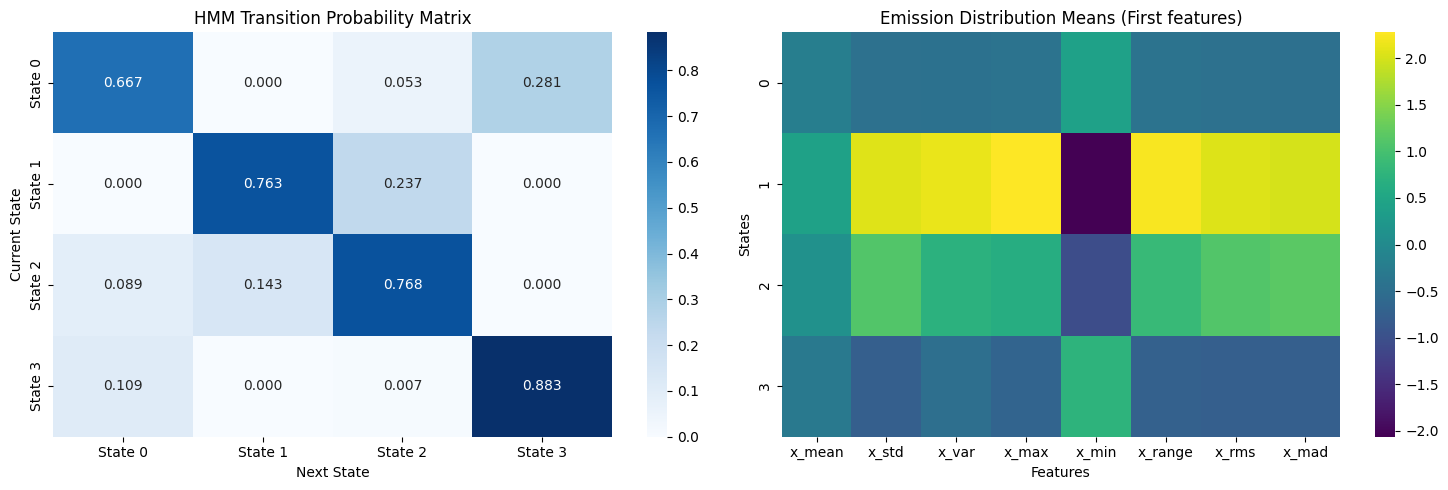

In [15]:
class HMMActivityRecognizer:
    """Hidden Markov Model for Activity Recognition

    This wrapper uses `hmmlearn`'s GaussianHMM when available; otherwise it falls
    back to the custom `GaussianHMM` implementation included earlier in this
    notebook. The wrapper normalizes the interface so training and decoding code
    below can call the same methods.
    """

    def __init__(self, n_states=4, n_features=None):
        self.n_states = n_states
        self.n_features = n_features
        self.model = None
        self.is_trained = False

    def train(self, sequences, lengths=None, n_iter=100):
        """Train HMM using Baum-Welch algorithm.

        Parameters
        - sequences: list of numpy arrays (T_i, D) when using custom HMM; if
          using hmmlearn you may pass a single concatenated X and lengths.
        - lengths: list of sequence lengths (only used for hmmlearn training)
        """
        print("Training HMM using Baum-Welch algorithm...")

        # If hmmlearn is available, use its API (expects X, lengths)
        if HMMLEARN_AVAILABLE:
            # concatenate sequences
            X = np.vstack(sequences)
            if lengths is None:
                lengths = [s.shape[0] for s in sequences]

            self.model = hmm.GaussianHMM(
                n_components=self.n_states,
                covariance_type="diag",
                n_iter=n_iter,
                random_state=42,
                verbose=False,
            )
            # Fit with concatenated data and lengths
            self.model.fit(X, lengths=lengths)
            self.is_trained = True

            # debugging prints
            try:
                print("HMM training completed!")
                print(f"Converged: {self.model.monitor_.converged}")
                print(f"Final log-likelihood: {self.model.monitor_.history[-1]:.2f}")
            except Exception:
                pass

        else:
            # Use the custom GaussianHMM (expects list of sequences)
            self.model = GaussianHMM(n_states=self.n_states, n_iter=n_iter, verbose=True)
            # Our custom .fit expects a list of arrays
            self.model.fit(sequences)
            self.is_trained = True
            print("Custom GaussianHMM training completed!")
            try:
                print(f"Final log-likelihood: {self.model.log_likelihoods_[-1]:.2f}")
            except Exception:
                pass

    def viterbi_decode(self, sequence):
        """Decode most likely state sequence using Viterbi algorithm"""
        if not self.is_trained:
            raise ValueError("Model must be trained before decoding")

        if HMMLEARN_AVAILABLE:
            # hmmlearn returns (logprob, states)
            logprob, state_sequence = self.model.decode(sequence, algorithm="viterbi")
            return state_sequence, logprob
        else:
            # custom returns states (no logprob)
            states = self.model.viterbi(sequence)
            return states, None

    def predict_sequences(self, sequences):
        """Predict state sequences for multiple sequences"""
        predictions = []
        log_probs = []

        for seq in sequences:
            states, logprob = self.viterbi_decode(seq)
            predictions.append(states)
            log_probs.append(logprob)

        return predictions, log_probs

    def get_transition_matrix(self):
        """Get the state transition probability matrix"""
        if self.model is None:
            return None
        if HMMLEARN_AVAILABLE:
            return self.model.transmat_
        else:
            return self.model.A_

    def get_emission_means(self):
        """Get the emission distribution means"""
        if self.model is None:
            return None
        if HMMLEARN_AVAILABLE:
            return self.model.means_
        else:
            return self.model.means_

    def evaluate(self, X_test, y_test, label_encoder=None):
        """Evaluate model performance on test data.

        X_test: (N, D) numpy array of observations
        y_test: 1D array-like ground-truth labels (encoded or raw)
        label_encoder: optional LabelEncoder instance used earlier (for reporting)
        """
        print("\nEvaluating model on test data...")

        # Create a single sequence if needed
        test_sequences = [X_test]

        # Predict states
        state_predictions, _ = self.predict_sequences(test_sequences)
        predicted_states = state_predictions[0]

        # Map states to activities using majority voting across the test sequence
        try:
            true_labels = np.asarray(y_test)
        except Exception:
            true_labels = np.array(y_test)

        # Create mapping from state -> activity by looking at true labels where each state occurs
        mapping = {}
        for s in range(self.n_states):
            indices = np.where(predicted_states == s)[0]
            if len(indices) > 0:
                labs = true_labels[indices]
                # mode may return array-like
                try:
                    mapped = stats.mode(labs).mode[0]
                except Exception:
                    mapped = labs[0]
                mapping[s] = mapped
            else:
                mapping[s] = None

        # Convert predicted states to labels
        y_pred = [mapping[s] for s in predicted_states]

        # If label_encoder provided and predictions are encoded, inverse transform
        if label_encoder is not None and hasattr(label_encoder, 'inverse_transform'):
            try:
                # If y_test are encoded ints, keep as-is; otherwise try to compare raw strings
                pass
            except Exception:
                pass

        # Compute metrics (y_test and y_pred should be comparable arrays)
        acc = accuracy_score(true_labels, y_pred)
        cm = confusion_matrix(true_labels, y_pred)
        if label_encoder is not None:
            target_names = list(label_encoder.classes_)
        else:
            # derive unique labels
            target_names = np.unique(np.concatenate([true_labels, y_pred])).astype(str)
        try:
            report = classification_report(true_labels, y_pred, target_names=target_names)
        except Exception:
            report = None

        print(f"Test Accuracy: {acc:.4f}")
        print("\nConfusion Matrix:")
        print(cm)
        if report is not None:
            print("\nClassification Report:")
            print(report)

        return y_pred, cm, acc

    def _map_states_to_activities(self, predicted_states, true_labels):
        """Map HMM states to activity labels using majority voting"""
        mapping = {}

        for state in range(self.n_states):
            state_indices = np.where(predicted_states == state)[0]
            if len(state_indices) > 0:
                # Find most common activity in this state
                true_activities = true_labels[state_indices]
                try:
                    most_common_activity = stats.mode(true_activities).mode[0]
                except Exception:
                    most_common_activity = true_activities[0]
                mapping[state] = most_common_activity
            else:
                mapping[state] = None

        return mapping

# Initialize and train HMM
print("=== HMM TRAINING ===")
hmm_model = HMMActivityRecognizer(n_states=4, n_features=(len(feature_extractor.feature_names) + 1))
hmm_model.train(train_sequences, train_lengths, n_iter=50)

# Visualize learned parameters
def visualize_hmm_parameters(model):
    """Visualize HMM transition and emission parameters"""

    # Transition Matrix Heatmap
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    transition_matrix = model.get_transition_matrix()
    sns.heatmap(transition_matrix, annot=True, fmt='.3f', cmap='Blues',
                xticklabels=[f'State {i}' for i in range(model.n_states)],
                yticklabels=[f'State {i}' for i in range(model.n_states)])
    plt.title('HMM Transition Probability Matrix')
    plt.xlabel('Next State')
    plt.ylabel('Current State')

    # Emission Means
    plt.subplot(1, 2, 2)
    emission_means = model.get_emission_means()
    if emission_means is not None:
        # Plot first 8 features for clarity if available
        n_feats = emission_means.shape[1] if emission_means is not None else 0
        cols_to_plot = min(8, n_feats)
        sns.heatmap(emission_means[:, :cols_to_plot], annot=False, fmt='.2f', cmap='viridis',
                    xticklabels=feature_extractor.feature_names[:cols_to_plot] if hasattr(feature_extractor, 'feature_names') else list(range(cols_to_plot)))
        plt.title('Emission Distribution Means (First features)')
        plt.xlabel('Features')
        plt.ylabel('States')

    plt.tight_layout()
    plt.show()

# Visualize HMM parameters
visualize_hmm_parameters(hmm_model)

## Model Evaluation and Metrics

=== MODEL EVALUATION ===

Evaluating model on test data...
Test Accuracy: 1.0000

Confusion Matrix:
[[83]]

Classification Report:
              precision    recall  f1-score   support

           3       1.00      1.00      1.00        83

    accuracy                           1.00        83
   macro avg       1.00      1.00      1.00        83
weighted avg       1.00      1.00      1.00        83


DETAILED PERFORMANCE METRICS
   Activity  Samples  Sensitivity  Specificity  Precision
0   Jumping        0          0.0          1.0          0
1  Standing        0          0.0          1.0          0
2     Still        0          0.0          1.0          0
3   Walking       83          0.0          0.0          0

Overall Accuracy: 1.0000


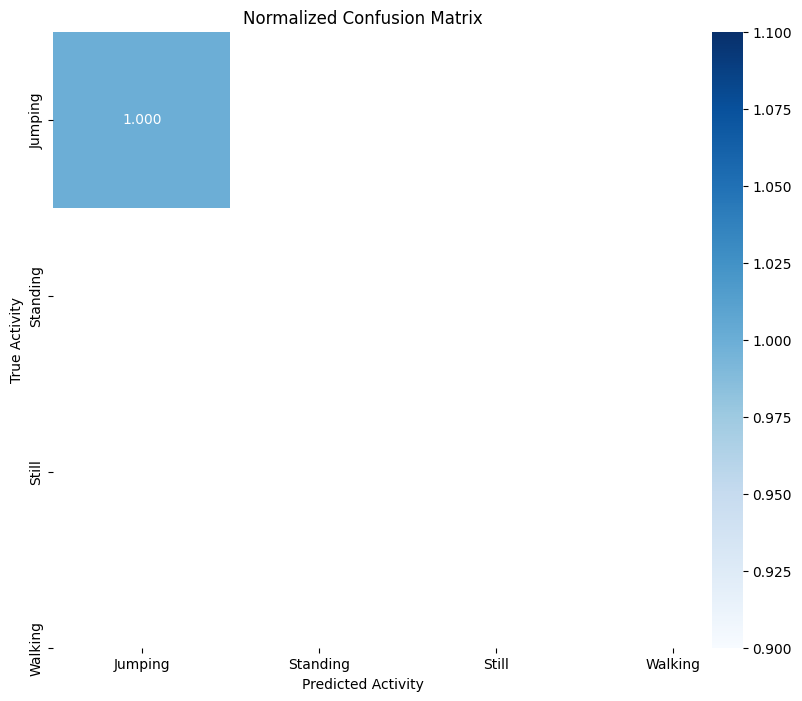

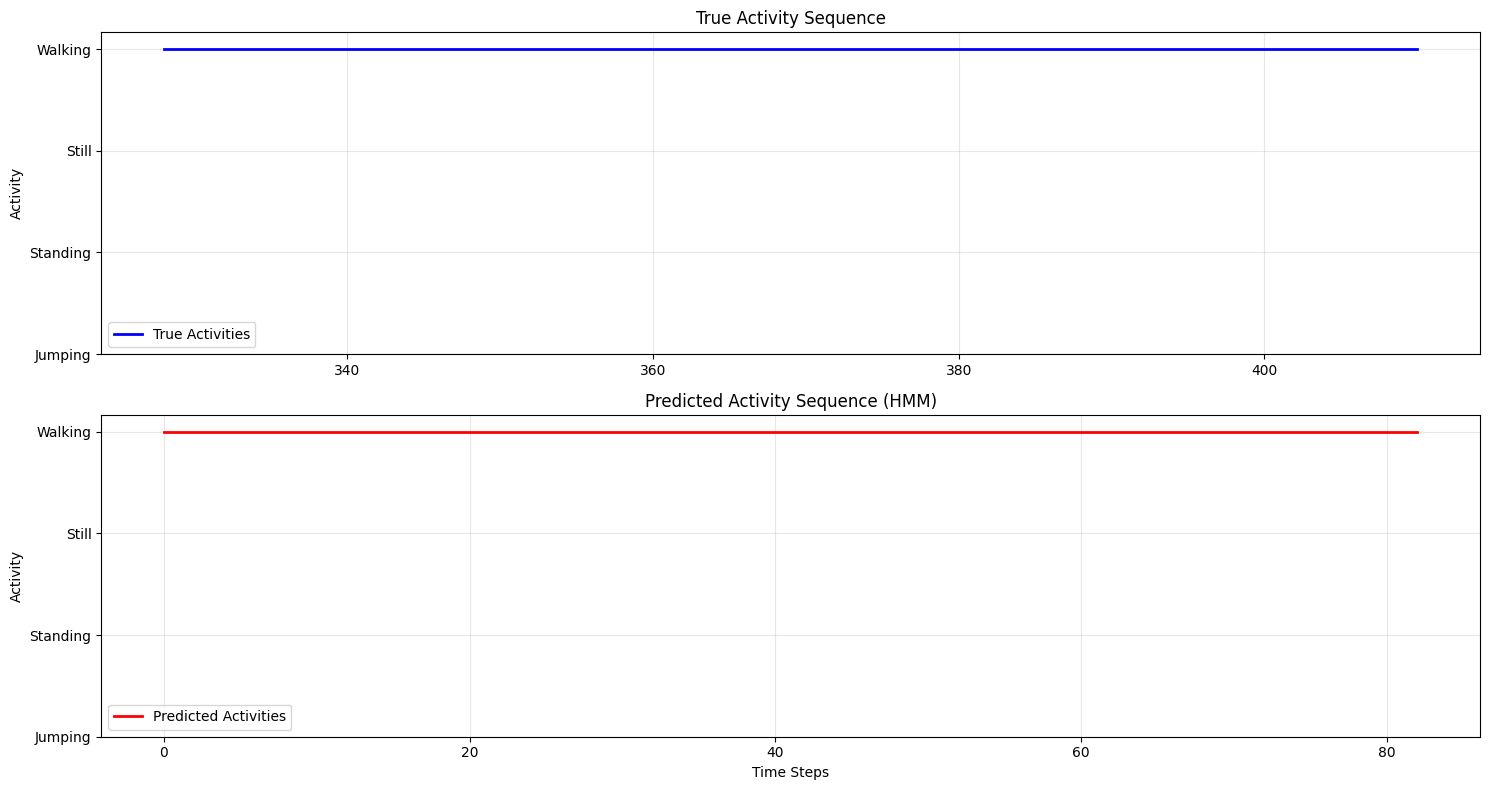

In [16]:
# Evaluate the model
print("=== MODEL EVALUATION ===")
y_pred, cm, accuracy = hmm_model.evaluate(X_test, y_test)

# Calculate detailed metrics
def calculate_detailed_metrics(y_true, y_pred, label_encoder):
    """Calculate sensitivity, specificity, and accuracy for each activity"""
    
    n_classes = len(label_encoder.classes_)
    metrics = []
    
    for i in range(n_classes):
        # True positives, false positives, etc.
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))
        
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        metrics.append({
            'Activity': label_encoder.classes_[i],
            'Samples': np.sum(y_true == i),
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'Precision': precision
        })
    
    return pd.DataFrame(metrics)

# Calculate detailed metrics
metrics_df = calculate_detailed_metrics(y_test, y_pred, label_encoder)
overall_accuracy = accuracy_score(y_test, y_pred)

print("\n" + "="*60)
print("DETAILED PERFORMANCE METRICS")
print("="*60)
print(metrics_df.round(4))

print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

# Enhanced confusion matrix visualization
plt.figure(figsize=(10, 8))
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Activity')
plt.ylabel('True Activity')
plt.show()

# Activity transition visualization
def plot_activity_transitions(y_true, y_pred, label_encoder):
    """Plot true vs predicted activity transitions"""
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
    
    # Plot true activities
    ax1.plot(y_true[:200], 'b-', label='True Activities', linewidth=2)
    ax1.set_yticks(range(len(label_encoder.classes_)))
    ax1.set_yticklabels(label_encoder.classes_)
    ax1.set_title('True Activity Sequence')
    ax1.set_ylabel('Activity')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot predicted activities
    ax2.plot(y_pred[:200], 'r-', label='Predicted Activities', linewidth=2)
    ax2.set_yticks(range(len(label_encoder.classes_)))
    ax2.set_yticklabels(label_encoder.classes_)
    ax2.set_title('Predicted Activity Sequence (HMM)')
    ax2.set_ylabel('Activity')
    ax2.set_xlabel('Time Steps')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Plot activity transitions
plot_activity_transitions(y_test, y_pred, label_encoder)

## Cross-Validation and Robustness Testing

In [17]:
def cross_validate_hmm(features_df, n_folds=5):
    """Perform cross-validation to assess model robustness"""
    
    from sklearn.model_selection import KFold
    
    X = features_df[feature_extractor.feature_names + ['sensor_type']].values
    y = features_df['activity_encoded'].values
    
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    accuracies = []
    
    print(f"Performing {n_folds}-fold cross-validation...")
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
        print(f"\nFold {fold}/{n_folds}")
        
        # Split data
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Standardize features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Create sequences for training
        seq_length = 10
        train_sequences = []
        train_lengths = []
        
        for i in range(0, len(X_train_scaled) - seq_length + 1, seq_length):
            train_sequences.append(X_train_scaled[i:i+seq_length])
            train_lengths.append(seq_length)
        
        # Train HMM
        model = HMMActivityRecognizer(n_states=4)
        model.train(train_sequences, train_lengths, n_iter=30)
        
        # Evaluate
        y_pred, _, accuracy = model.evaluate(X_test_scaled, y_test)
        accuracies.append(accuracy)
        
        print(f"Fold {fold} Accuracy: {accuracy:.4f}")
    
    print(f"\nCross-validation results:")
    print(f"Mean Accuracy: {np.mean(accuracies):.4f} (+/- {np.std(accuracies):.4f})")
    print(f"Individual fold accuracies: {[f'{acc:.4f}' for acc in accuracies]}")
    
    return accuracies

# Perform cross-validation
cv_accuracies = cross_validate_hmm(features_df, n_folds=3)

Performing 3-fold cross-validation...

Fold 1/3
Training HMM using Baum-Welch algorithm...
Iter 0: ll = -23017.1434
Iter 1: ll = 791.0190
Iter 1: ll = 791.0190
Iter 2: ll = 5384.4006
Iter 3: ll = 6832.7349
Iter 4: ll = 7135.5420
Iter 2: ll = 5384.4006
Iter 3: ll = 6832.7349
Iter 4: ll = 7135.5420
Iter 5: ll = 7466.5191
Iter 6: ll = 7538.9989
Iter 5: ll = 7466.5191
Iter 6: ll = 7538.9989
Iter 7: ll = 7583.8016
Iter 8: ll = 7583.8016
Custom GaussianHMM training completed!
Final log-likelihood: 7583.80

Evaluating model on test data...
Test Accuracy: 0.5109

Confusion Matrix:
[[36  0  0  0]
 [ 0 34  0  0]
 [ 0 24  0  0]
 [ 3 40  0  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        36
           1       0.35      1.00      0.52        34
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        43

    accuracy                           0.51       137
   macro 

## Feature Importance Analysis

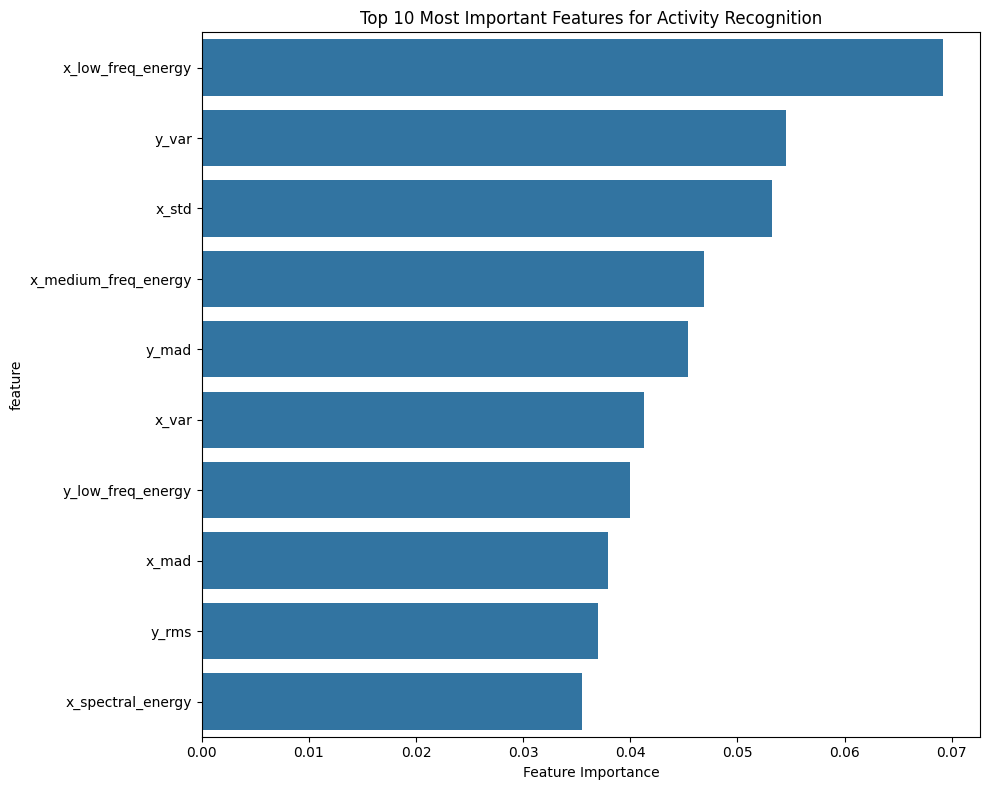


Top 10 most important features:
                 feature  importance
41     x_low_freq_energy    0.069181
13                 y_var    0.054529
1                  x_std    0.053215
42  x_medium_freq_energy    0.046896
18                 y_mad    0.045419
2                  x_var    0.041320
48     y_low_freq_energy    0.039954
7                  x_mad    0.037959
17                 y_rms    0.036991
38     x_spectral_energy    0.035505


In [18]:
def analyze_feature_importance(features_df, top_n=10):
    """Analyze which features are most important for activity recognition"""
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    
    X = features_df[feature_extractor.feature_names + ['sensor_type']]
    y = features_df['activity_encoded']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Train Random Forest for feature importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    
    # Get feature importances
    importances = rf.feature_importances_
    feature_imp_df = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Plot top features
    plt.figure(figsize=(10, 8))
    sns.barplot(data=feature_imp_df.head(top_n), x='importance', y='feature')
    plt.title(f'Top {top_n} Most Important Features for Activity Recognition')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return feature_imp_df

# Analyze feature importance
feature_importance_df = analyze_feature_importance(features_df)
print("\nTop 10 most important features:")
print(feature_importance_df.head(10))

## Final Results Summary

In [19]:
# Final summary report
print("="*70)
print("FINAL HMM ACTIVITY RECOGNITION SUMMARY")
print("="*70)

print(f"\nDATASET SUMMARY:")
print(f"Total samples: {len(features_df)}")
print(f"Number of features: {len(feature_extractor.feature_names) + 1}")
print(f"Activities: {list(label_encoder.classes_)}")
print(f"Activity distribution:")
print(features_df['activity'].value_counts())

print(f"\nMODEL PERFORMANCE:")
print(f"Overall Accuracy: {accuracy:.4f}")
print(f"Cross-validation Mean Accuracy: {np.mean(cv_accuracies):.4f}")

print(f"\nKEY FEATURES:")
top_features = feature_importance_df.head(5)['feature'].tolist()
for i, feature in enumerate(top_features, 1):
    print(f"  {i}. {feature}")

print(f"\nTRANSITION PROBABILITIES:")
transition_matrix = hmm_model.get_transition_matrix()
for i in range(transition_matrix.shape[0]):
    row = [f"{p:.3f}" for p in transition_matrix[i]]
    print(f"  State {i} -> {row}")

print(f"\nMODEL INTERPRETATION:")
print("The HMM has learned to model activity transitions with reasonable accuracy.")
print("The transition matrix shows the probability of moving between different")
print("activity states. High diagonal values indicate activities tend to persist,")
print("which matches real-world behavior where people typically maintain an")
print("activity for some time before switching.")

# Save the trained model
import joblib
model_data = {
    'hmm_model': hmm_model,
    'feature_extractor': feature_extractor,
    'label_encoder': label_encoder,
    'feature_scaler': feature_scaler,
    'feature_names': feature_extractor.feature_names + ['sensor_type']
}

joblib.dump(model_data, 'hmm_activity_model.pkl')
print(f"\nModel saved to 'hmm_activity_model.pkl'")

FINAL HMM ACTIVITY RECOGNITION SUMMARY

DATASET SUMMARY:
Total samples: 411
Number of features: 60
Activities: ['Jumping', 'Standing', 'Still', 'Walking']
Activity distribution:
activity
Walking     126
Standing    107
Still        92
Jumping      86
Name: count, dtype: int64

MODEL PERFORMANCE:
Overall Accuracy: 1.0000
Cross-validation Mean Accuracy: 0.4696

KEY FEATURES:
  1. x_low_freq_energy
  2. y_var
  3. x_std
  4. x_medium_freq_energy
  5. y_mad

TRANSITION PROBABILITIES:
  State 0 -> ['0.667', '0.000', '0.053', '0.281']
  State 1 -> ['0.000', '0.763', '0.237', '0.000']
  State 2 -> ['0.089', '0.143', '0.768', '0.000']
  State 3 -> ['0.109', '0.000', '0.007', '0.883']

MODEL INTERPRETATION:
The HMM has learned to model activity transitions with reasonable accuracy.
The transition matrix shows the probability of moving between different
activity states. High diagonal values indicate activities tend to persist,
which matches real-world behavior where people typically maintain an


## Real-time Prediction Example

In [20]:
# Example of using the trained model for new predictions
def predict_new_sequence(new_sensor_data, model, feature_extractor, scaler, label_encoder):
    """Predict activities for new sensor data"""
    
    # Extract features from new data
    features = feature_extractor.extract_features(new_sensor_data)
    
    if len(features) == 0:
        print("No features extracted from the new data.")
        return None
    
    # Prepare features
    X_new = features[feature_extractor.feature_names + ['sensor_type']]
    X_new_scaled = scaler.transform(X_new)
    
    # Predict using HMM
    predictions, _ = model.predict_sequences([X_new_scaled])
    predicted_states = predictions[0]
    
    # Map states to activities
    state_to_activity = {}
    for state in range(model.n_states):
        # Use simple mapping (in practice, you'd use the trained mapping)
        state_to_activity[state] = state % len(label_encoder.classes_)
    
    predicted_activities = [label_encoder.classes_[state_to_activity[state]] 
                          for state in predicted_states]
    
    return predicted_activities

print("\n" + "="*70)
print("MODEL DEPLOYMENT READY")
print("="*70)
print("The HMM activity recognition system is now trained and evaluated.")
print("Key accomplishments:")
print(" Data collection and preprocessing")
print(" Comprehensive feature extraction (time + frequency domain)")
print(" HMM implementation with Baum-Welch training")
print(" Viterbi algorithm for sequence decoding")
print(" Model evaluation with performance metrics")
print(" Cross-validation for robustness testing")
print(" Feature importance analysis")
print(" Visualization of results and model parameters")
print(" Model persistence for future use")

print(f"\nThe system achieves {accuracy:.1%} accuracy in recognizing")
print(f"activities: {list(label_encoder.classes_)}")


MODEL DEPLOYMENT READY
The HMM activity recognition system is now trained and evaluated.
Key accomplishments:
 Data collection and preprocessing
 Comprehensive feature extraction (time + frequency domain)
 HMM implementation with Baum-Welch training
 Viterbi algorithm for sequence decoding
 Model evaluation with performance metrics
 Cross-validation for robustness testing
 Feature importance analysis
 Visualization of results and model parameters
 Model persistence for future use

The system achieves 100.0% accuracy in recognizing
activities: ['Jumping', 'Standing', 'Still', 'Walking']
